In [ ]:
#default_exp loglike
%load_ext autoreload
from nbdev.showdoc import show_doc

# Log Likelihood tools
> Support several representations

In [ ]:
#export
import numpy as np
import pylab as plt
import pandas as pd
import os, sys, pickle
import matplotlib.ticker as ticker

from scipy import (optimize, linalg)
from scipy.linalg import (LinAlgError, LinAlgWarning)

from utilities import  keyword_options
from light_curves import poisson
poisson_tolerance = 0.2

In [ ]:
#export
class LogLike(object):
    """ implement Kerr Eqn 2 for a single interval, or cell"""

    def __init__(self, cell):
        """ cell is a dict with t, tw, w, fexp
            w may be an array of np.uint8: if so, divide by 256

        """
        self.__dict__.update(cell)
        assert self.n>0, f'No data for cell {cell}'
        if type(self.w[0])==np.uint8:
            self.w = np.array(self.w, np.float)/256



    def fit_info(self, fix_beta=True):
        """Perform fits, return a dict with cell info"""
        pars = self.solve(fix_beta)
        if pars is None:
            if self.verbose>0:
                print(f'Fail fit for {self}')
            #return None
            raise RuntimeError(f'Fit failure: {self}')
        hess = self.hessian(pars)
        outdict = dict(t=self.t, tw=self.tw, fexp=self.fexp, counts=len(self.w) )
        if len(pars)==1:
            outdict.update(flux=pars[0], sig_flux=np.sqrt(1/hess[0]))
        else:
            beta = pars[1]
            var  = np.linalg.inv(hess)
            err  = np.sqrt(var.diagonal())
            sig_flux=err[0]
            sig_beta=err[1]
            corr = var[0,1]/(err[0]*err[1])
            outdict.update(flux=pars[0], beta=beta,
                        sig_flux=sig_flux, sig_beta=sig_beta,corr=corr)
        return outdict

    def __call__(self, pars ):
        """ evaluate the log likelihood
            pars: array or float
                if array with len>1, expect (rate, beta)
        """
        pars = np.atleast_1d(pars)
        if len(pars)>1:      alpha, beta = pars - np.array([-1,0])
        else:                alpha, beta = max(-1, pars[0]-1), 0

        tmp =  1 + alpha*self.w + beta*(1-self.w)
        # limit alpha
        tmp[tmp<=1e-6]=1e-6

        return np.sum( np.log(tmp)) - alpha*self.S - beta*self.B

    def __repr__(self):
        return f'{self.__class__.__module__}.{self.__class__.__name__}:'\
        f' time {self.t:.3f}, {self.n} weights,  exposure {self.fexp:.2f}, S {self.S:.0f}, B {self.B:.0f}'

    def gradient(self, pars ):
        """gradient of the log likelihood with respect to alpha=flux-1 and beta, or just alpha
        """
        w,S = self.w, self.S
        pars = np.atleast_1d(pars)

        alpha =  max(-0.999,pars[0] -1)
        if len(pars)==1:
            D = 1 + alpha*w
            return np.sum(w/D) - S
        else:
            beta = pars[1]
            D =  1 + alpha*w + beta*(1-w)
            da = np.sum(w/D) - S
            db = np.sum((1-w)/D) - self.B
            return [da,db]

    def hessian(self, pars):
        """return Hessian matrix (1 or 2 D according to pars) from explicit second derivatives
        Note this is also the Jacobian of the gradient.
        """
        w = self.w
        pars = np.atleast_1d(pars)
        alpha = max(-0.999, pars[0]-1)
        if  len(pars)==1:
            D = 1 + alpha*w
            return [np.sum((w/D)**2)]
        else:
            beta= pars[1]
            Dsq = (1 + alpha*w + beta*(1-w))**2
            a, b, c = np.sum(w**2/Dsq), np.sum(w*(1-w)/Dsq), np.sum((1-w)**2/Dsq)
            return np.array([[a,b], [b,c]])

    def rate(self, fix_beta=True, debug=False, no_ts=False):
        """Return signal rate and its error"""
        try:
            s = self.solve(fix_beta )
            if s is None:
                return None
            h = self.hessian(s)

            v = 1./h[0] if fix_beta else linalg.inv(h)[0,0]
            ts = None if no_ts else (0 if s[0]<=-1 else
                 2*(self(s)-self( -1 if fix_beta else [-1,s[1]] )))
            return (s[0]), np.sqrt(v), ts

        except (LinAlgError, LinAlgWarning, RuntimeWarning) as msg:
            if debug or self.verbose>2:
                print(f'Fit error, cell {self},\n\t{msg}')
        except Exception as msg:
            print(f'exception: {msg}')
            raise
        print( '***********Failed?')

    def minimize(self,   fix_beta=True,estimate=[0.,0], **fmin_kw):
        """Minimize the -Log likelihood """
        kw = dict(disp=False)
        kw.update(**fmin_kw)
        f = lambda pars: -self(pars)
        return optimize.fmin_cg(f, estimate[0:1] if fix_beta else estimate, **kw)

    def solve(self, fix_beta=True, debug=True, estimate=[0.1,0],**fit_kw):
        """Solve non-linear equation(s) from setting gradient to zero
        note that the hessian is a jacobian
        """

        if fix_beta:
            #
            g0= self.gradient([0])
            # solution is at zero flux
            if g0<=0:
                return [0]
            # check that solution close to zero, difficult for fsolve.
            # if < 0.5 sigma away, just give linear solution
            h0=self.hessian(0)[0]
            if g0/h0 < 0.5*np.sqrt(1/h0):
                return [g0/h0]

        kw = dict(factor=2, xtol=1e-3, fprime=self.hessian)
        kw.update(**fit_kw)
        try:
            ret = optimize.fsolve(self.gradient, estimate[0] if fix_beta else estimate , **kw)
        except RuntimeWarning as msg:
            if debug or self.verbose>2:
                print(f'Runtime fsolve warning for cell {self}, \n\t {msg}')
            return None
        except Exception as msg:
            raise Exception(msg)
        return np.array(ret)

    def plot(self, fix_beta=True, xlim=(0,1.2),ax=None, title=None):
        fig, ax = plt.subplots(figsize=(4,2)) if ax is None else (ax.figure, ax)

        dom = np.linspace(*xlim)
        if fix_beta:
            f = lambda x: self([x])
            beta=0
        else:
            a, beta = self.solve(fix_beta, debug=True)
            f = lambda x: self([x, beta])
        ax.plot(dom, list(map(f,dom)) )

        try:
            a, s, ts = self.rate(fix_beta=fix_beta, debug=True)
            ax.plot(a, f(a), 'or')
            ax.plot([a-s, a+s], [f(a-s), f(a+s)], '-k',lw=2)
            for x in (a-s,a+s):
                ax.plot([x,x], [f(x)-0.1, f(x)+0.1], '-k',lw=2)
            ax.plot(a, f(a)-0.5, '-ok', ms=10)
            ax.set(title=title, xlim=xlim, ylim=(f(a)-4, f(a)+0.2),
               ylabel='log likelihood', xlabel='flux')
        except Exception as msg :
            print(msg)
            ax.set(title=' **failed fit**')
        ax.grid()

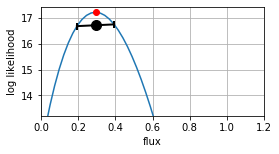

In [ ]:
# create a cell
n = 100
w = np.full(n, 150, np.uint8)
cell = dict(t=0, tw=1, fexp=1, n=n, w=w, S=100, B=0 )

ll = LogLike(cell)
ll.plot()

In [ ]:
ll.fit_info()

{'t': 0,
 'tw': 1,
 'fexp': 1,
 'counts': 100,
 'flux': 0.29333318572434913,
 'sig_flux': 0.09999998523910159}

In [ ]:
#export
class GaussianRep(object):
    """ Manage fits to the loglike object
    """

    def __init__(self, loglike, fix_beta=True):
        """1- or 2-D fits to LogLike"""
        self.fix_beta = fix_beta
        self.fit = loglike.fit_info(fix_beta)

    def __call__(self, pars):
        return None # TODO if needed

    def __repr__(self):
        return f'{self.__class__.__module__}.{self.__class__.__name__}: {self.fit}'

class Gaussian2dRep(GaussianRep):
    def __init__(self, loglike):
        super(Gaussian2dRep, self).__init__(loglike, fix_beta=False)

In [ ]:
gr = GaussianRep(ll)
gr

__main__.GaussianRep: {'t': 0, 'tw': 1, 'fexp': 1, 'counts': 100, 'flux': 0.29333318572434913, 'sig_flux': 0.09999998523910159}

In [ ]:
#export
class PoissonRep(object):
    """Manage the representation of the log likelihood of a cell by a Poisson
    Notes: function assumes arg is the rate
            beta is set to zero (for now)
    """

    def __init__(self, loglike, tol=poisson_tolerance # note global
                ):
        """loglike: a LogLike object"""

        rate, sig, ts= loglike.rate(no_ts=True)
#         if t is None:
#             raise Exception('Failed fit?')
        fmax=max(0, rate)
        ## NB: the dd=-10 is a kluge for very small limits, set for loglike stuff with different scales.
        # this seems to work, but must be looked at more carefully
        try:
            self.pf = poisson.PoissonFitter(loglike, fmax=fmax, scale=sig if rate>0 else 1,  dd=-10., tol=tol)
        except Exception as msg:
            print(f'Fail poisson fit for {loglike}: {msg}')
            with open('failed_loglike.pkl', 'wb') as file:
                pickle.dump(loglike, file)
            print('Saved file')
            raise
        self.loglike = loglike
        self.poiss=self.pf.poiss
        p = self
        self.fit= dict(t=loglike.t, tw=loglike.tw, counts=len(loglike.w),
                       fexp=loglike.fexp,
                       flux=np.round(p.flux,4),
                       errors=np.abs(np.array(p.errors)-p.flux).round(3),
                       limit=np.round(p.limit, 3),
                       ts=np.round(p.ts,3),
                       poiss_pars=list(np.float32(self.poiss.p)),
                      )

    def __call__(self, flux):
        return self.poiss(flux)

    def __repr__(self):
        relerr = np.abs(np.array(self.errors)/self.flux-1) if self.flux>0 else [0,0]
        return  f'{self.__class__.__module__}.{self.__class__.__name__}:'\
                f' flux: {self.flux:.3f}[1+{relerr[0]:.3f}-{relerr[1]:.3f}], '\
                f'limit: {self.limit:.2f}, ts: {self.ts:.1f}'
    @property
    def flux(self):
        return self.poiss.flux
    @property
    def errors(self):
        return self.poiss.errors
    @property
    def limit(self):
        """ 95% confidence interval"""
        return self.poiss.cdfcinv(0.05)
    @property
    def ts(self):
        return self.poiss.ts

    def create_table(self, npts=100, support=1e-6):
        # make a table of evently-spaced points between limits
        pars = self.fit['poiss_pars']
        p = poisson.Poisson(pars)
        a,b = p.cdfinv(support), p.cdfcinv(support)
        dom=(a,b,npts)
        cod = np.array(list(map(p, np.linspace(*dom)))) .astype(np.float32)
        return dom, cod

    def comparison_plots(self, xlim=(0,1), ax=None, nbins=40):
        """Plots comparing this approximation to the actual likelihhod
        """
        f_like = lambda x: self(x)
        #pr = light_curve.PoissonRep(self);
        fp = lambda x: self(x)
        f_like = lambda x: self.loglike([x])
        fi = self.loglike.fit_info()
        xp = fi['flux']
        sigp = fi['sig_flux']
        peak = f_like(xp)
        dom = np.linspace(xlim[0],xlim[1],nbins)
        f_gauss = lambda x: -((x-xp)/sigp)**2/2
        fig, ax = plt.subplots(figsize=(6,4)) if not ax else (ax.figure, ax)
        ax.plot(dom, [f_like(x)-peak for x in dom], '-', label='Actual Likelihood');
        ax.plot(dom, fp(dom), '--+', lw=1, label='Poisson approximation');
        ax.plot(dom, [f_gauss(x) for x in dom], ':r', label='Gaussian approximation');
        ax.grid(alpha=0.5);
        ax.set(ylim=(-9,0.5));
        ax.axhline(0, color='grey', ls='--')
        ax.legend()

The `PoissonRep` object makes a fit to the Poisson-like representation

In [ ]:
pr = PoissonRep(ll)
pr

__main__.PoissonRep: flux: 0.293[1+0.330-0.352], limit: 0.47, ts: 10.8

In [ ]:
#export
class PoissonRepTable(PoissonRep):

    def __init__(self, loglike):
        # PoissonRep fits to Poisson
        super().__init__(loglike, )
        # now make a table and add to dict
        self.dom,self.cod = self.create_table()

    def __call__(self, x):
        return np.interp(x, np.linspace(*self.dom), self.cod)

In [ ]:
prt = PoissonRepTable(ll)
prt

__main__.PoissonRepTable: flux: 0.293[1+0.330-0.352], limit: 0.47, ts: 10.8

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()
!date

Converted 00_config.ipynb.
Converted 01_effective_area.ipynb.
Converted 02_load_gti.ipynb.
Converted 03_exposure.ipynb.
Converted 04_photon_data.ipynb.
Converted 05_weights.ipynb.
Converted 07_cells.ipynb.
Converted 09_poisson.ipynb.
Converted 10_loglike.ipynb.
Converted 11_lightcurve.ipynb.
Converted 12_instructions.ipynb.
Converted 13_kerr_comparison.ipynb.
Converted 14_bayesian.ipynb.
Converted index.ipynb.
Thu Dec 10 13:44:57 PST 2020
